In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants 
from scipy.interpolate import CubicSpline

# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly
from meteostat import Stations

In [136]:
#Constants
#Vessel properties 
D = 0.3 #Diameter vessel
D = np.linspace(0.05,0.3,3) #Diameter vessel
L = np.linspace(0.00001,0.3,3) #Lenght vessel

# Create a 2-D grid for D and L
D, L = np.meshgrid(D, L)

# Now D and L are 2-D arrays containing all combinations of diameter and length
V = D**2/4*np.pi*L  # [m^3]
A = D*L + D**2/4*np.pi  # [m^2]

rho_vessel = 2.7e3 # aluminium [kg/m3]
t_vessel = 0.5e-3 # Thickness [m]
m_vessel = A*t_vessel*rho_vessel
c_vessel = 890 #J/kg aluminium

#Air 
#T_amb = 20+273 
rho_air=1.293 #kgm-3 
m_air = rho_air*V 
R = constants.R #J/K*molz
c_air = 718 #j/kg K constant volume
P_amb = 1e5
n_mass = 28.96747 #molar mass [g/mol]
n = m_air/n_mass
cp = 1000 #J/kgK @ 300 K
cv = 718 #J/kgK @ 300k
y = cp/cv
K = 273.15

#Combined properties
m = m_vessel+m_air
c = m_vessel/m*c_vessel+m_air/m*c_air





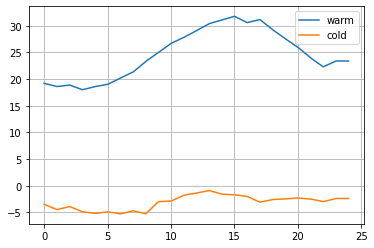

In [173]:
# Get nearby weather stations
stations = Stations()
stations = stations.nearby(52.35660593196212, 4.948958216497039)
station = stations.fetch(1)

# Print DataFrame
#print(station)

# Set time period
start1 = datetime(2023, 7, 8)
end1 = datetime(2023, 7, 9)

# Get hourly data
data_warm = Hourly(station, start1, end1)
data_warm = data_warm.fetch()

# Print DataFrame
#print(data_warm)

# Set time period
start2 = datetime(2022, 12, 13) #Coldest day https://www.knmi.nl/nederland-nu/klimatologie/maand-en-seizoensoverzichten/2023/winter
end2 = datetime(2022, 12, 14)

# Get hourly data
data_cold = Hourly(station, start2, end2)
data_cold = data_cold.fetch()

# Create an array for each hour in the day, converted to seconds
dt=1 # Second
day_length = 24 * 60 * 60  # length of a day in seconds
time_steps = np.linspace(0, day_length, num=day_length // dt + 1)  # time steps
hours = np.arange(24)*60*60

# Interpolate the temperature data to a per-second basis
T_amb_w = np.interp(time_steps, hours, data_warm['temp'][0:len(hours)].values)
T_amb_c = np.interp(time_steps, hours, data_cold['temp'][0:len(hours)].values)

# Plot the data
plt.plot(time_steps/3600, T_amb_w,label='warm')
plt.plot(time_steps/3600, T_amb_c,label='cold')
plt.grid()
plt.legend()
plt.show()




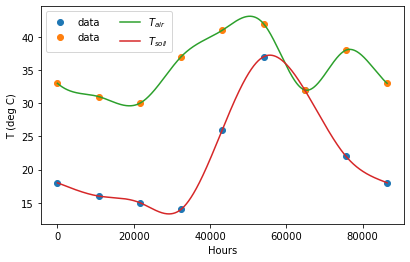

In [138]:
#Fit soil T data from paper
#https://geothermal-energy-journal.springeropen.com/articles/10.1186/s40517-017-0082-z
Time_fit = np.linspace(0,24*3600,9)
T_a = [33,31,30,37,41,42,32,38,33]
T_s = [18,16,15,14,26,37,32,22,18]


T_soil = CubicSpline(Time_fit, T_s,bc_type='periodic')
T_air = CubicSpline(Time_fit, T_a,bc_type='periodic')
xs = np.arange(0,24*3600, 0.1)

fig, ax = plt.subplots(figsize=(6.5, 4))

ax.plot(Time_fit,T_s, 'o', label='data')
ax.plot(Time_fit,T_a, 'o', label='data')
ax.plot(xs, T_air(xs), label="$T_{air}$")
ax.plot(xs, T_soil(xs), label="$T_{soil}$")

ax.legend(ncol=2)
plt.xlabel('Hours')
plt.ylabel('T (deg C)')

plt.show()

In [139]:
#Power calculation
A_exposed= 0.5*A

#Q_rad
e = 0.9 # emissvity factor black epoxy
sigma = constants.sigma

# Solar constant at solar noon
#Source: https://en.tutiempo.net/solar-radiation/amsterdam.html
I_noon = 800 # W/m^2 

# Calculate solar constant for each time step
solar_constants = I_noon * np.sin(0.25*day_length+2*np.pi * time_steps / day_length)

# Set solar constant to zero during the night
solar_constants[solar_constants < 0] = 0

alpha=25#[W/M^2K] Convection heat transfer coeficient

# Find the dimensions of A_exposed
num_rows, num_cols = A_exposed.shape

# Initialize the v_flow array with zeros
v_flow = np.zeros((num_rows, num_cols))
P_all = np.zeros((num_rows, num_cols, day_length+1)) 
T_all = np.zeros((num_rows, num_cols, day_length+1))  # Save P for all ii, jj, and time_steps
D2= np.zeros((num_rows, num_cols))

#T_sim = T_soil(time_steps[i])+K
#T_sim = T_air(time_steps[i])+K
T_sim = T_amb_w[i] #already in K

# Loop over all elements of A_exposed
for ii in range(num_rows):
    for jj in range(num_cols):
        T   = np.zeros(day_length+1)
        P   = np.zeros(day_length+1)
        Q_rad = np.zeros(day_length+1)
        Q_con = np.zeros(day_length+1)

        for i in range(len(time_steps)):
            if i==0:
                T[i] = T_amb_w[i] 
                P[i] = P_amb
            else:
                Q_rad[i]=e*sigma*A[ii,jj]*(T[i-1]**4-T_amb_w[i] **4)
                Q_con[i]=alpha*A[ii,jj]*(T[i-1]-T_amb_w[i] )
                P_sun = solar_constants[i]*A_exposed[ii,jj]*dt
                T[i] = (P_sun-Q_rad[i]-Q_con[i]) /(m[ii,jj]*c[ii,jj])+T[i-1]
                P[i] = T[i]/T[i-1]*P[i-1]
                if i == len(time_steps)-1:
                    print('huray')
                    n1=max(P)*V[ii,jj]/(R*max(T)) 
                    n2=P_amb*V[ii,jj]/(R*max(T))                     
                    v_flow [ii,jj]=((n1-n2)*R*T_amb_w[i] /P_amb)*1000
        # Store the P array for this ii, jj combination
        P_all[ii, jj, :] = P    
        T_all[ii, jj, :] = T    
                    




huray
huray
huray
huray
huray
huray
huray
huray
huray


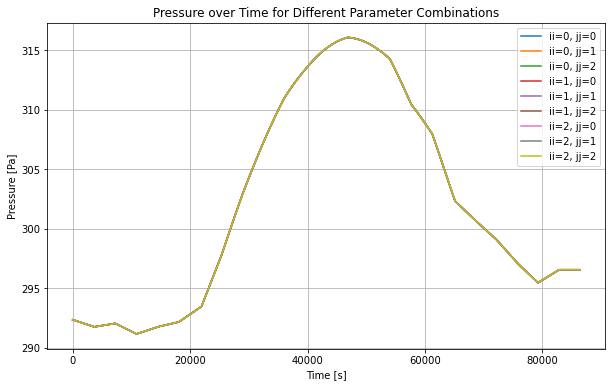

In [140]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Loop over all elements of A_exposed
for ii in range(num_rows):
    for jj in range(num_cols):
        plt.plot(time_steps, T_all[ii, jj, :], label=f"ii={ii}, jj={jj}")

plt.xlabel('Time [s]')
plt.ylabel('Pressure [Pa]')
plt.title('Pressure over Time for Different Parameter Combinations')
plt.legend()  # Show a legend
plt.grid(True)
plt.show()

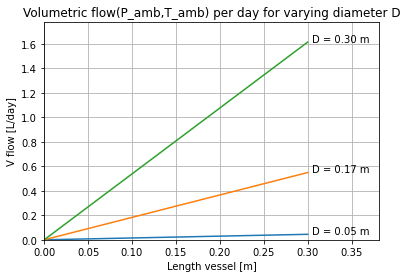

In [141]:
for idx in range(v_flow.shape[0]):
    plt.plot(L[:,idx], v_flow[:,idx])
    final_x = L[-1,idx]+0.005  # Get the final x value (i.e., final length)
    final_y = v_flow[-1,idx]  # Get the final y value (i.e., final flow)
    plt.text(final_x, final_y, "D = {:.2f} m".format(D[1,idx]))  # Add text annotation

plt.ylabel('V flow [L/day]')
plt.xlabel('Length vessel [m]')
plt.title("Volumetric flow(P_amb,T_amb) per day for varying diameter D")
plt.xlim(0,final_x*1.25)
plt.ylim(0,final_y*1.1)
plt.grid()
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


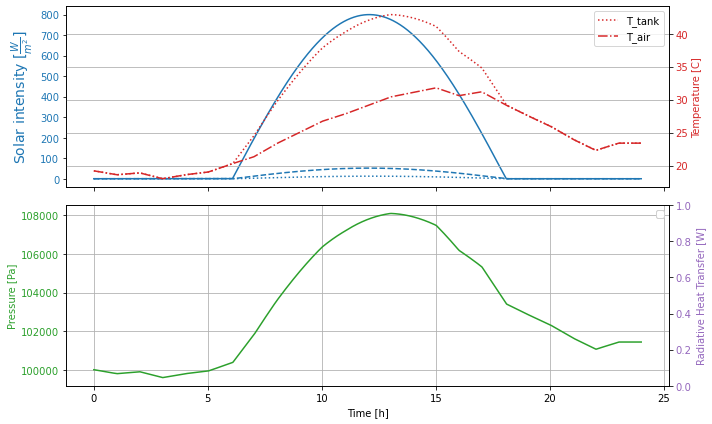

In [153]:
fig, axs = plt.subplots(2, 1,figsize=(10, 6), sharex=True)  # Creates two subplots and makes their x-axes align

# Plot the solar_constants on the primary y-axis of the first subplot
color = 'tab:blue'
axs[0].set_ylabel('Solar intensity' r' $[\frac{W}{m^2}]$', color=color, fontsize=14)

axs[0].plot(time_steps/3600, solar_constants, color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[0].plot(time_steps/3600, Q_rad, color=color,linestyle=':',label='Q_rad')  
axs[0].plot(time_steps/3600, Q_con, color=color,linestyle='--',label='Q_con')
plt.legend()
plt.grid()

# Create a second y-axis that shares the same x-axis, and plot T on this axis
ax2 = axs[0].twinx() 
color = 'tab:red'
ax2.set_ylabel('Temperature [C]', color=color) 
ax2.plot(time_steps/3600, T-K, color=color,linestyle=':',label='T_tank')
#ax2.plot(time_steps/3600, T_soil(time_steps), color=color,linestyle='--',label='T_soil')
#ax2.plot(time_steps/3600, T_air(time_steps), color=color,linestyle='-.',label='T_air')
ax2.plot(time_steps/3600, T_amb_w-K, color=color,linestyle='-.',label='T_air')
ax2.tick_params(axis='y', labelcolor=color)
#plt.ylim(0,66)
plt.grid()
plt.legend()

# Plot P on the primary y-axis of the second subplot
color = 'tab:green'
axs[1].set_ylabel('Pressure [Pa]', color=color)
axs[1].plot(time_steps/3600, P, color=color)  # Assuming P is your pressure data
axs[1].tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second subplot, and plot Q_rad on this axis
ax4 = axs[1].twinx()
color = 'tab:purple'
ax4.set_ylabel('Radiative Heat Transfer [W]', color=color) 
#ax4.plot(time_steps/3600, Q_rad, color=color,linestyle=':',label='Q_rad')  
#ax4.plot(time_steps/3600, Q_con, color=color,linestyle='--',label='Q_con')
ax4.tick_params(axis='y', labelcolor=color)
plt.legend()

axs[1].set_xlabel('Time [h]')



# Show the plot
plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()




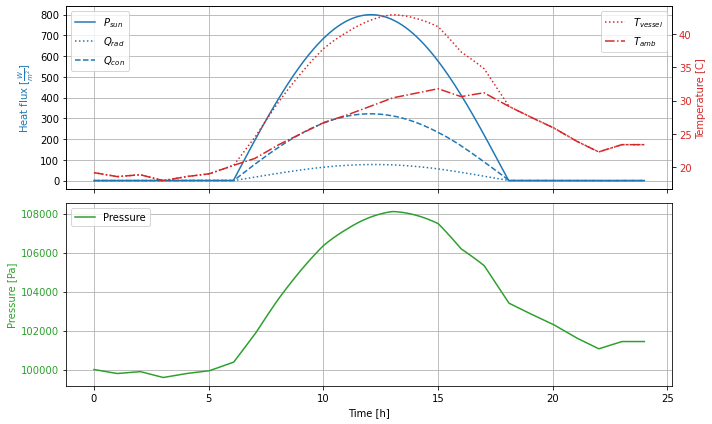

In [169]:
fig, axs = plt.subplots(2, 1,figsize=(10, 6), sharex=True) 
# Plot the solar_constants on the primary y-axis of the first subplot
color = 'tab:blue'
axs[0].set_ylabel('Heat flux' r' $[\frac{W}{m^2}]$', color=color)
line1, = axs[0].plot(time_steps/3600, solar_constants, color=color, label='$P_{sun}$')
line2, = axs[0].plot(time_steps/3600, Q_rad/A[2,2], color=color,linestyle=':',label='$Q_{rad}$')  
line3, = axs[0].plot(time_steps/3600, Q_con/A[2,2], color=color,linestyle='--',label='$Q_{con}$')

# Create a second y-axis that shares the same x-axis, and plot T on this axis
ax2 = axs[0].twinx() 
color = 'tab:red'
ax2.set_ylabel('Temperature [C]', color=color) 
line4, = ax2.plot(time_steps/3600, T-K, color=color,linestyle=':',label='T_tank')
line5, = ax2.plot(time_steps/3600, T_amb_w-K, color=color,linestyle='-.',label='T_air')
ax2.tick_params(axis='y', labelcolor=color)

# Add a legend manually
axs[0].legend([line1, line2, line3], ['$P_{sun}$', '$Q_{rad}$', '$Q_{con}$'], loc='upper left')
ax2.legend([line4, line5], ['$T_{vessel}$', '$T_{amb}$'], loc='upper right')


# Plot P on the primary y-axis of the second subplot
color = 'tab:green'
axs[1].set_ylabel('Pressure [Pa]', color=color)
line6, = axs[1].plot(time_steps/3600, P, color=color)  # Assuming P is your pressure data
axs[1].tick_params(axis='y', labelcolor=color)
#axs[0].legend(loc='upper left', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
#ax2.legend(loc='upper left', bbox_to_anchor=(1.2, 0.5), borderaxespad=0.)

# Create a second y-axis for the second subplot, and plot Q_rad on this axis
#ax4 = axs[1].twinx()
color = 'tab:purple'
#ax4.set_ylabel('Radiative Heat Transfer [W]', color=color) 
#ax4.plot(time_steps/3600, Q_rad, color=color,linestyle=':',label='Q_rad')  
#ax4.plot(time_steps/3600, Q_con, color=color,linestyle='--',label='Q_con')
ax4.tick_params(axis='y', labelcolor=color)


# Add a legend manually for the second subplot
axs[1].legend([line6], ['Pressure'], loc='upper left')
# ax4 doesn't have any lines plotted, so we don't need to add a legend for it

axs[1].set_xlabel('Time [h]')

# Show the plot
plt.tight_layout()  # Adjusts the spacing between subplots
axs[0].grid(True)
axs[1].grid(True)

plt.show()




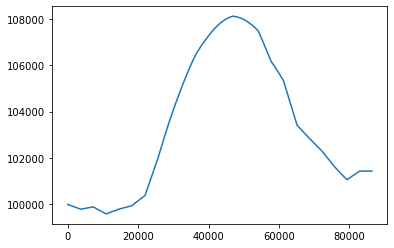

In [147]:
plt.plot(time_steps, P)
plt.show()